In [1]:
import warnings
warnings.filterwarnings('ignore')

import shap
from acv_explainers import ACVTree
from acv_explainers.utils import *
from experiments.exp_linear_gmm import *

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns

import random 
import numpy as np
import pandas as pd

random.seed(212)
np.random.seed(212)

plt.style.use('ggplot')

### Load data and model

In [2]:
X = pd.read_csv('/home/samoukou/Documents/ACV/data/lucas0_train.csv')
X.head()

y = X.Lung_cancer.values
X.drop(['Lung_cancer'], axis=1, inplace=True)

n_estimators = 1
num_features = X.shape[1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Model 
tree = DecisionTreeClassifier(min_samples_leaf=20, random_state=212)
tree.fit(X_train, y_train)

accuracy_train = roc_auc_score(y_train, tree.predict_proba(X_train)[:, 1])
accuracy_test = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
print('[* TREE *]')
print('train acc = {} --- test acc = {}'.format(accuracy_train, accuracy_test))

forest = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=5, random_state=212, 
                                max_samples=0.8, max_depth=4)
forest.fit(X_train, y_train)
forest.estimators_[0] = tree

accuracy_train = roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])
accuracy_test = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
print('[* FOREST *]')
print('train acc = {} --- test acc = {}'.format(accuracy_train, accuracy_test))

[* TREE *]
train acc = 0.9230919439227646 --- test acc = 0.9127666666666667
[* FOREST *]
train acc = 0.9230919439227646 --- test acc = 0.9127666666666667


### Let's choose an observation to explain

In [3]:
# idx = np.random.randint(0, 400)
idx = 174
ind = X_test.values[idx]
y_ind = y_test[idx]
fx = forest.predict(np.expand_dims(ind, 0))[0]
print('f(x) = {}, y_ind = {}'.format(fx, y_ind))
X_test[idx:idx+1]

f(x) = 1, y_ind = 1


,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing
533,1,1,0,0,0,0,0,1,1,1,1


### Build ACVTree for explanations

In [4]:
acvtree = ACVTree(forest, X_train.values)

### Find $S^\star$

In [5]:
# params init 

sdp_cluster = []
threshold = 0.5
proba = 0.95
decay = 0.77
index = list(range(X.shape[1]))
algo = 'plugin'
data = X_train.values

acvtree.compute_local_sdp_clf(ind, fx, threshold, proba, index, data, sdp_cluster, decay, verbose=0, C=[[5, 6]])

print('Cluster find by SDP = {}'.format(sdp_cluster))

sdp_importance = []
for c in sdp_cluster:
    value = [acvtree.compute_sdp_clf(ind, fx, threshold, S=chain_l(c), 
             data=data) for i in range(len(forest.estimators_))]

    sdp_importance.append(np.mean(value))

sdp_importance

sdp_importance_name = []
for c in sdp_cluster:
    sdp_importance_name.append(str([X.columns[i] for i in c]))

Cluster find by SDP = [[0, 10], [1, 2, 3, 4, 7, 8, 9, 5, 6]]


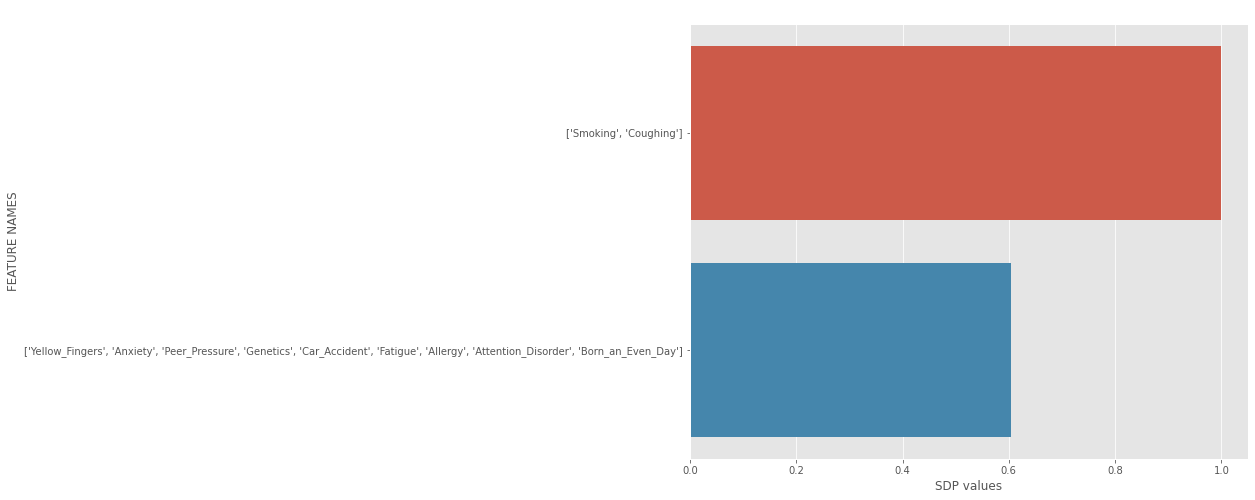

In [6]:
plot_feature_importance(sdp_importance, sdp_importance_name, 'forest_SDP  ', xlabel='SDP values', title=' ')

In [7]:
# from scipy.special import comb

# def powerset(iterable):
#     s = list(iterable)
#     return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s) + 1))

# from scipy.special import comb

# def vote_exp_clf(x, fx, tx, pi, forest, S, data, algo="plugin"):
#     if len(S) == 0:
#         return 0
#     sdp = cond_sdp_forest_clf(x, fx, tx, forest, S, data=data, algo=algo)
#     return sdp


# def tree_shap_vote_clf(tree, x,  tx, fx, pi, algo, data=None, C=[[]]):
#     """
#     Compute Classic Shapley values of a tree_classifier of x

#     Args:
#         tree (DecisionTreeClassifier):
#         x (array): observation
#         algo (string): name of the estimators, recommended 'plugin'
#         data (array): data used to compute the Shapley values
#         C (list[list]): list of the different coalition of variables by their index

#     Returns:
#         array: Shapley values of x
#     """
#     m = len(x)
#     va_id = list(range(m))
#     va_id_buffer = va_id.copy()

#     if C[0] != []:
#         for c in C:
#             m -= len(c)
#             va_id = list(set(va_id) - set(c))
#         m += len(C)
#         for c in C:
#             va_id += [c]

#     phi = np.zeros(len(x))
    
#     for i in va_id:
#         if C[0] != []:
#             Sm = list(set(va_id_buffer) - set(convert_list(i)))
#             for c in C:
#                 if c != convert_list(i):
#                     Sm = list(set(Sm) - set(c))
#             for c in C:
#                 if c != convert_list(i):
#                     Sm += [c]
#         else:
#             Sm = list(set(va_id_buffer) - set(convert_list(i)))

#         for S in tqdm(powerset(Sm)):
#             phi[chain_l(i)] +=\
#                 comb(m-1, len(S))**(-1)*(vote_exp_clf(x=x, fx=fx, tx=tx, pi=pi, forest=tree, S=chain_l(S)+convert_list(i), data=data, algo=algo) - \
#                 vote_exp_clf(x=x, fx=fx, tx=tx, pi=pi, forest=tree, S=chain_l(S), data=data, algo=algo))
#     return phi/m
            
# #     for p in tqdm(itertools.permutations(va_id)):
# #         for i in range(m):
# #             phi[chain_l(p[i])] += \
# #                 vote_exp(x=x, fx=fx, tx=tx, pi=pi, forest=tree, S=chain_l(p[:i+1]), data=data, algo=algo) - \
# #                 vote_exp(x=x, fx=fx, tx=tx, pi=pi, forest=tree, S=chain_l(p[:i]), data=data, algo=algo)
# #     return phi / math.factorial(m)

In [8]:
# sv = tree_shap_vote_clf(forest, x=ind, tx=0.5, fx=fx, pi=0.95, algo='plugin', data=X_train.values, C=[[]])
# sv

In [9]:
# from scipy.special import comb

# def powerset(iterable):
#     s = list(iterable)
#     return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s) + 1))

# from scipy.special import comb

# def vote_exp_clf(x, fx, tx, pi, forest, S, data, algo="plugin"):
#     if len(S) == 0:
#         return 0
#     sdp = cond_sdp_forest_clf(x, fx, tx, forest, S, data=data, algo=algo)
#     return int(sdp >=pi)


# def tree_shap_vote_clf(tree, x,  tx, fx, pi, algo, data=None, C=[[]]):
#     """
#     Compute Classic Shapley values of a tree_classifier of x

#     Args:
#         tree (DecisionTreeClassifier):
#         x (array): observation
#         algo (string): name of the estimators, recommended 'plugin'
#         data (array): data used to compute the Shapley values
#         C (list[list]): list of the different coalition of variables by their index

#     Returns:
#         array: Shapley values of x
#     """
#     m = len(x)
#     va_id = list(range(m))
#     va_id_buffer = va_id.copy()
    
#     if C[0] != []:
#         for c in C:
#             m -= len(c)
#             va_id = list(set(va_id) - set(c))
#         m += len(C)
#         for c in C:
#             va_id += [c]

#     phi = np.zeros(len(x))
#     swings = {va:[0, 0] for va in va_id}
#     swings_prop = {va:[0, 0, 0] for va in va_id}
    
#     for i in va_id:
#         if C[0] != []:
#             Sm = list(set(va_id_buffer) - set(convert_list(i)))
#             for c in C:
#                 if c != convert_list(i):
#                     Sm = list(set(Sm) - set(c))
#             for c in C:
#                 if c != convert_list(i):
#                     Sm += [c]
#         else:
#             Sm = list(set(va_id_buffer) - set(convert_list(i)))

#         for S in powerset(Sm):
#             combinaison = comb(m-1, len(S))**(-1)
#             v_plus = vote_exp_clf(x=x, fx=fx, tx=tx, pi=pi, forest=tree, S=chain_l(S)+convert_list(i), data=data, algo=algo)
#             v_minus = vote_exp_clf(x=x, fx=fx, tx=tx, pi=pi, forest=tree, S=chain_l(S), data=data, algo=algo)
            
#             if v_plus - v_minus == 1:
#                 swings[i][0] += ((v_plus-v_minus)*combinaison)/m
#                 swings_prop[i][0] += 1
#             elif v_plus - v_minus == -1:
#                 swings[i][1] += ((v_plus-v_minus)*combinaison)/m
#                 swings_prop[i][1] += 1
#             else:
#                 swings_prop[i][2] += 1
            
#             phi[chain_l(i)] += combinaison*(v_plus - v_minus)
#     return phi/m, swings, swings_prop
            
# #     for p in tqdm(itertools.permutations(va_id)):
# #         for i in range(m):
# #             phi[chain_l(p[i])] += \
# #                 vote_exp(x=x, fx=fx, tx=tx, pi=pi, forest=tree, S=chain_l(p[:i+1]), data=data, algo=algo) - \
# #                 vote_exp(x=x, fx=fx, tx=tx, pi=pi, forest=tree, S=chain_l(p[:i]), data=data, algo=algo)
# #     return phi / math.factorial(m)

# # sv = tree_shap_vote_clf(forest, x=ind, tx=0.5, fx=fx, pi=0.95, algo='plugin', data=X_train.values, C=[[]])
# # sv

In [10]:
# def global_shap(forest, x, tx, fx, pi, algo='plugin', data=X_train.values, C=[[]]):
#     n = x.shape[0]
#     svs = []
#     swings = []
#     swings_prop = []
    
#     for i in tqdm(range(n)):
#             sv, swing, swing_prop = tree_shap_vote_clf(forest, x=x[i], tx=tx, fx=fx, pi=pi, algo=algo, data=data, C=C)
#             svs.append(sv)
#             swings.append(swing)
#             swings_prop.append(swing_prop)
#     return svs, swings, swings_prop
        

In [13]:
# pis = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.82, 0.85, 0.88, 0.9, 0.92, 0.95, 0.97]
pis = [0.7, 0.8, 0.82, 0.85, 0.88, 0.9, 0.92, 0.95, 0.97]
svs = []
swings = []
swings_prop = []
for pi in tqdm(pis):
    out = acvtree.shap_values_swing_clf(x=ind, tx=0.5, fx=fx, threshold=pi, data=X_train.values, C=[[]])
    sv, swing, swing_prop = out[0], out[1], out[2]
    svs.append(sv)
    swings.append(swing)
    swings_prop.append(swing_prop)

100%|██████████| 9/9 [17:50<00:00, 118.94s/it]


In [14]:
swing_prop

{0: [640, 0, 384],
 1: [0, 0, 1024],
 2: [0, 0, 1024],
 3: [0, 0, 1024],
 4: [0, 0, 1024],
 5: [0, 0, 1024],
 6: [0, 0, 1024],
 7: [0, 0, 1024],
 8: [128, 0, 896],
 9: [0, 128, 896],
 10: [384, 0, 640]}

In [15]:
swing

{0: [0.5833333333333326, 0],
 1: [0, 0],
 2: [0, 0],
 3: [0, 0],
 4: [0, 0],
 5: [0, 0],
 6: [0, 0],
 7: [0, 0],
 8: [0.08333333333333344, 0],
 9: [0, -0.0833333333333332],
 10: [0.41666666666666774, 0]}

In [23]:
svs = [s[:, 1] for s in svs]

In [24]:
color_line = {va: [] for va in swings[0].keys()}
for i in swings[0].keys():
    for pi_i, pi in enumerate(pis):
        color_line[i].append(swings_prop[pi_i][i][0]/np.sum(swings_prop[pi_i][i][:-1]))

In [25]:
for i in range(len(color_line)):
    color_line[i] = np.nan_to_num(color_line[i])

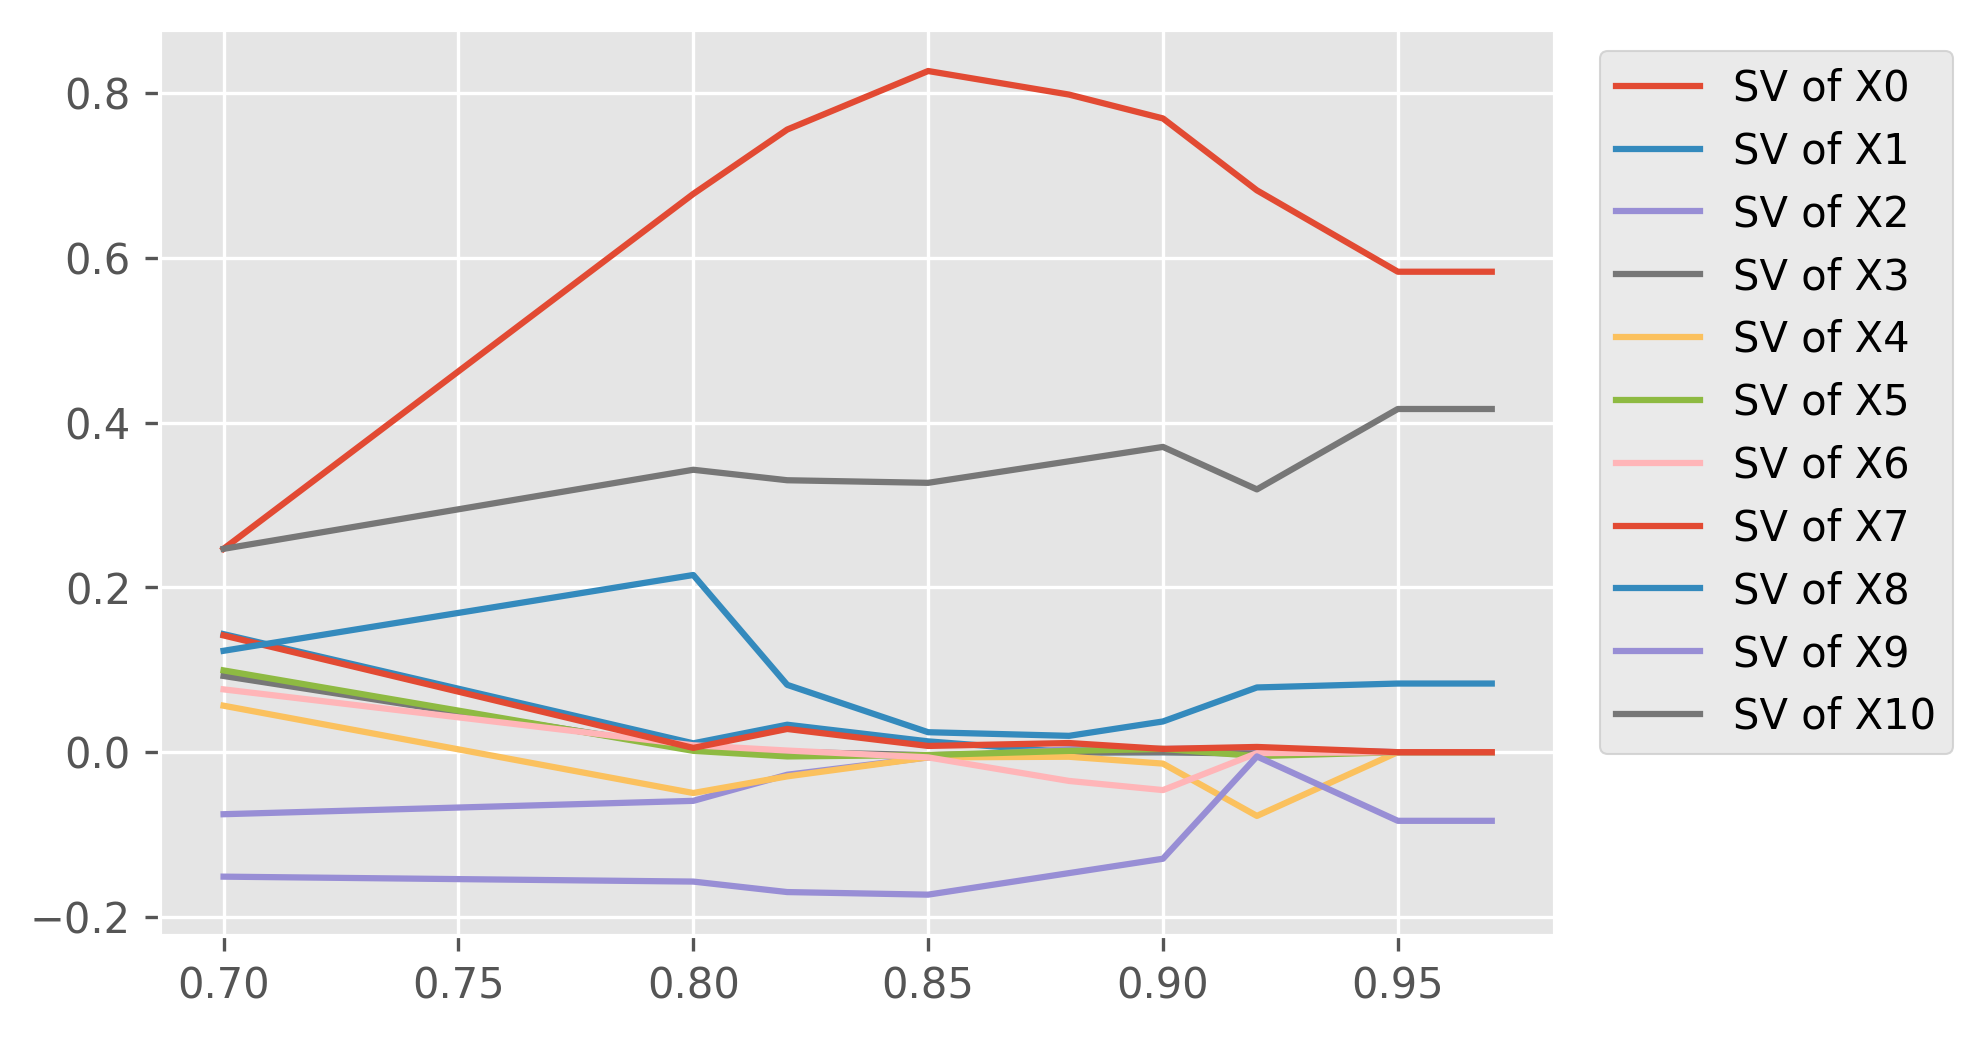

In [26]:
d = 11
svs_array = np.array(svs)
fig, ax = plt.subplots(dpi=300)
for i in range(d):
    ax.plot(pis, svs_array[:, i], label="SV of X{}".format(i))
ax.legend(bbox_to_anchor=(1.3, 1), loc="upper right")

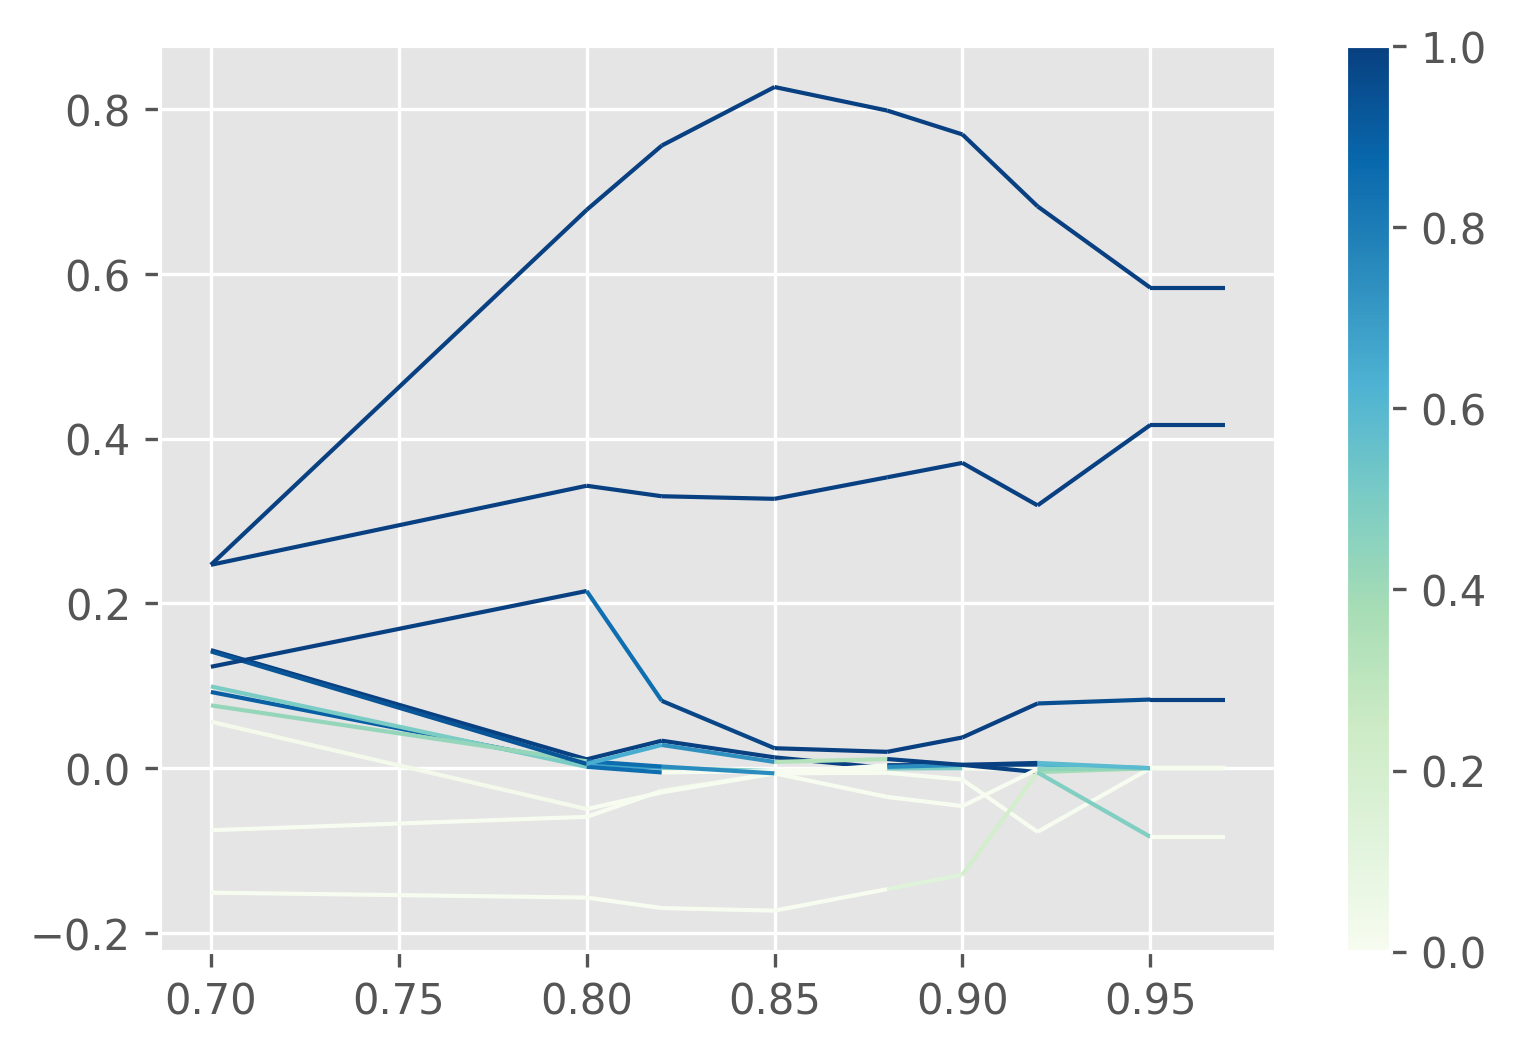

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np; np.random.seed(42)
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(dpi=300)

#convert dates to numbers first
for i in range(d):
    dates = pis
    y = svs_array[:, i]
    c = color_line[i]
    
    
    inxval = dates
    points = np.array([inxval, y]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.cm.GnBu, linewidth=1, norm=plt.Normalize(0.0, 1.0), label='{}'.format(i))
    ax.add_collection(lc)

    # set color to date values
    lc.set_array(c)
#     lc.set_color('black')
    
#     ax.xaxis_date()
    ax.autoscale_view()
# ax.legend()
fig.colorbar(lc, ax=ax)
plt.show()

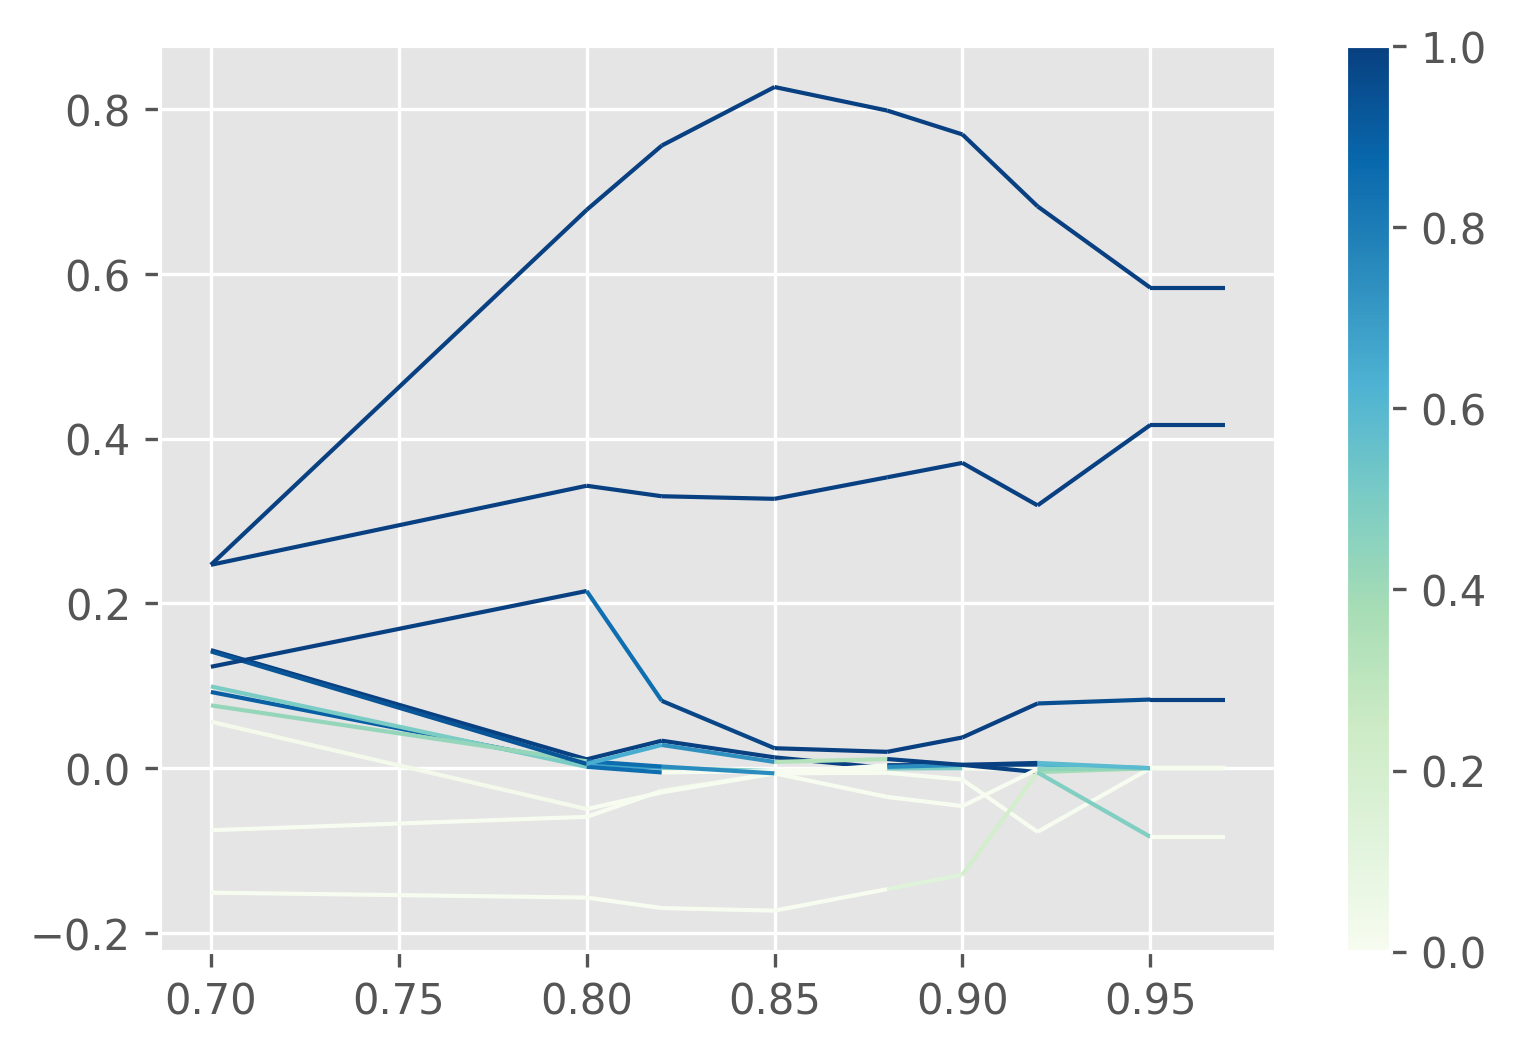

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np; np.random.seed(42)
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(dpi=300)

#convert dates to numbers first
for i in range(d):
    dates = pis
    y = svs_array[:, i]
    c = color_line[i]
    
    
    inxval = dates
    points = np.array([inxval, y]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.cm.GnBu, linewidth=1, norm=plt.Normalize(0.0, 1.0), label='{}'.format(i))
    ax.add_collection(lc)

    # set color to date values
    lc.set_array(c)
#     lc.set_color('black')
    
#     ax.xaxis_date()
    ax.autoscale_view()
# ax.legend()
fig.colorbar(lc, ax=ax)
plt.show()

In [29]:
pis_b = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

In [176]:
svs_b = []
swings_b = []
swings_prop_b = []
for pi in pis_b:
    out_b = acvtree.shap_values_swing_clf(x=ind, tx=0.5, fx=fx, threshold=pi, data=X_train.values, C=[[]])
    sv_b, swing_b, swing_prop_b = out_b[0], out_b[1], out_b[2]    
    swings_b.append(swing_b)
    swings_prop_b.append(swing_prop_b)

In [ ]:
svs_b = [s[:, 1] for s in svs_b]

In [179]:
pis = pis_b + pis
svs = svs_b + svs
swings = swings_b + swings
swings_prop = swings_prop_b + swings_prop 

In [191]:
color_line = {va: [] for va in swings[0].keys()}
for i in swings[0].keys():
    for pi_i, pi in enumerate(pis):
        color_line[i].append(swings_prop[pi_i][i][0]/np.sum(swings_prop[pi_i][i][:-1]))

In [192]:
for i in range(len(color_line)):
    color_line[i] = np.nan_to_num(color_line[i])

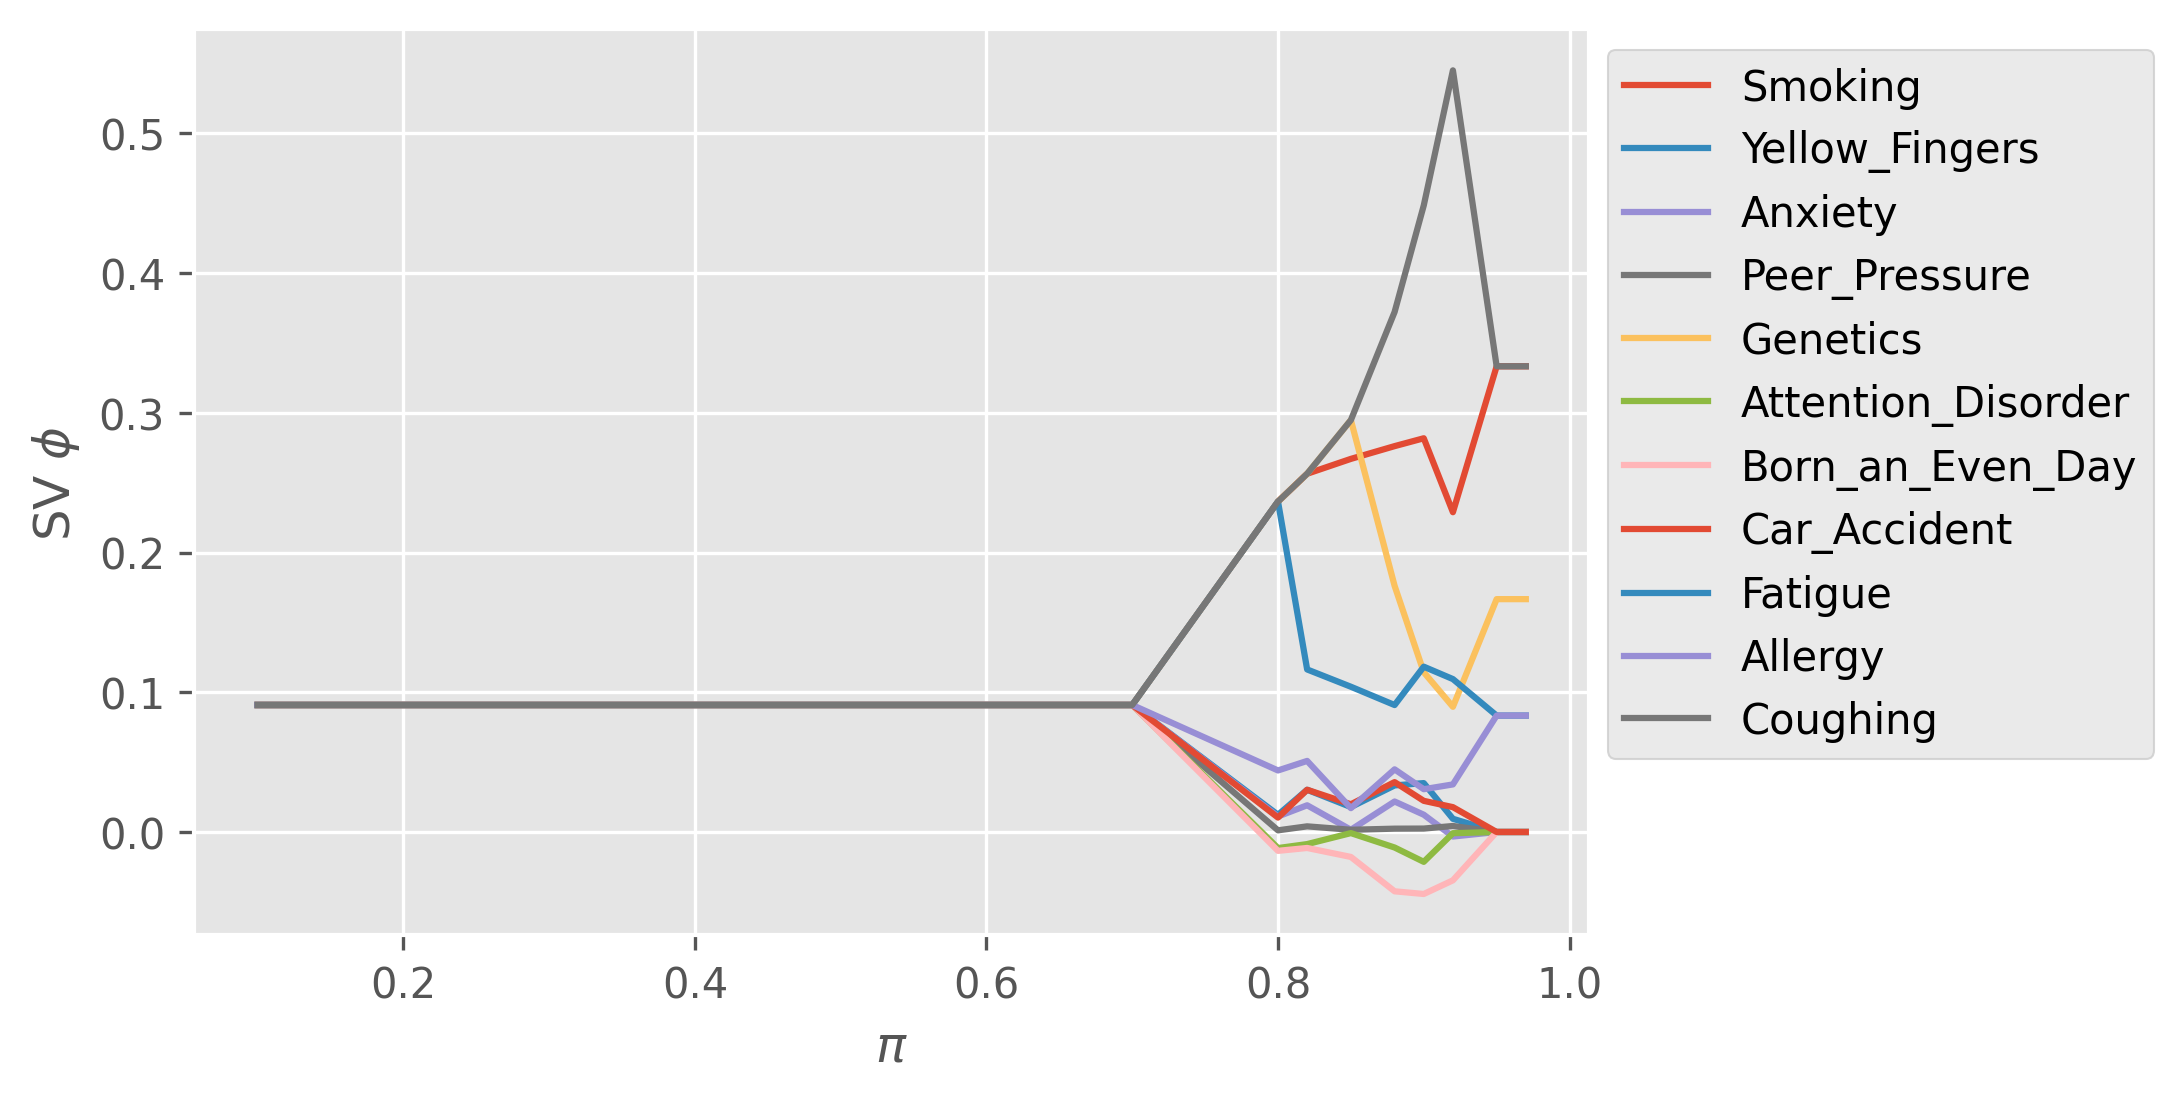

In [235]:
d = 11
svs_array = np.array(svs)
fig, ax = plt.subplots(dpi=300)
for i in range(d):
    ax.plot(pis, svs_array[:, i], label="{}".format(X.columns[i]))
ax.legend(bbox_to_anchor=(1.42, 1), loc="upper right")
ax.set_xlabel('$\pi$')
ax.set_ylabel('SV $\phi$')
plt.show()

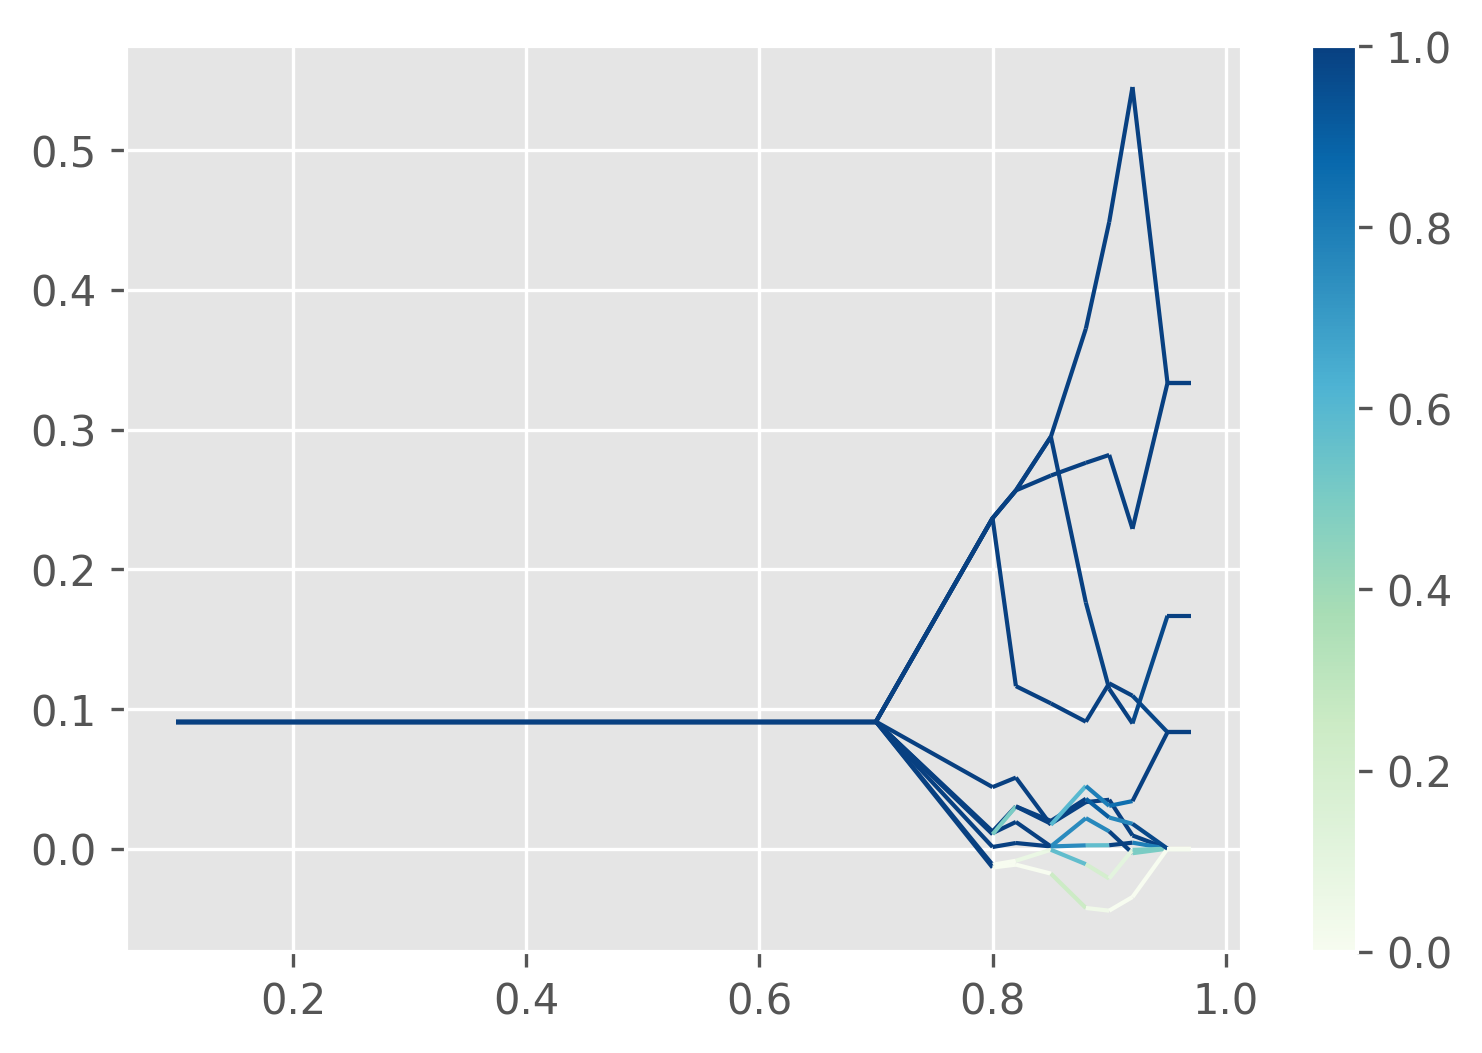

In [372]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np; np.random.seed(42)
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(dpi=300)

#convert dates to numbers first
for i in range(d):
    dates = pis
    y = svs_array[:, i]
    c = color_line[i]
    
    
    inxval = dates
    points = np.array([inxval, y]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.cm.GnBu, linewidth=1, norm=plt.Normalize(0.0, 1.0), label='{}'.format(i))
    ax.add_collection(lc)

    # set color to date values
    lc.set_array(c)
#     lc.set_color('black')
    
#     ax.xaxis_date()
    ax.autoscale_view()
# ax.legend()
fig.colorbar(lc, ax=ax)
plt.show()

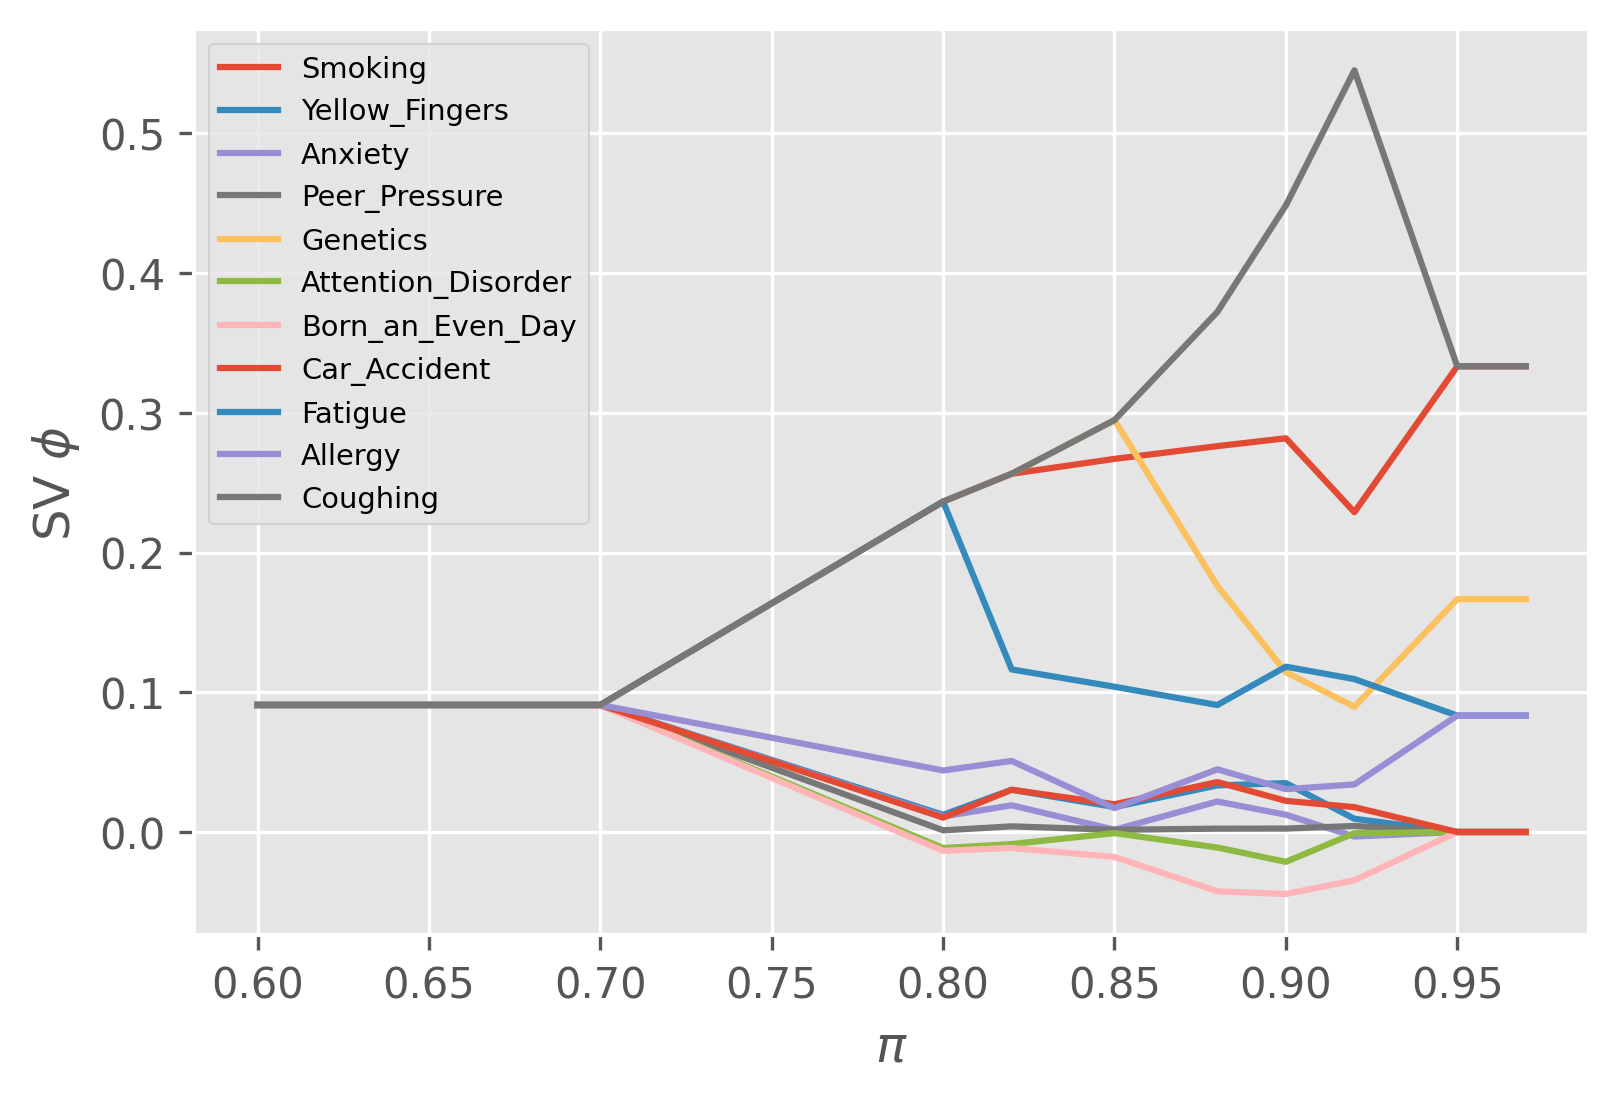

In [369]:
d = 11
svs_array = np.array(svs)
fig, ax = plt.subplots(dpi=300)
for i in range(d):
    ax.plot(pis[5:], svs_array[5:, i], label="{}".format(X_train.columns[i]))
ax.legend(bbox_to_anchor=(-0., 1), fontsize='x-small', loc="upper left", ncol=1)
ax.set_xlabel('$\pi$')
ax.set_ylabel('SV $\phi$')
plt.show()

In [433]:
tick = [0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]

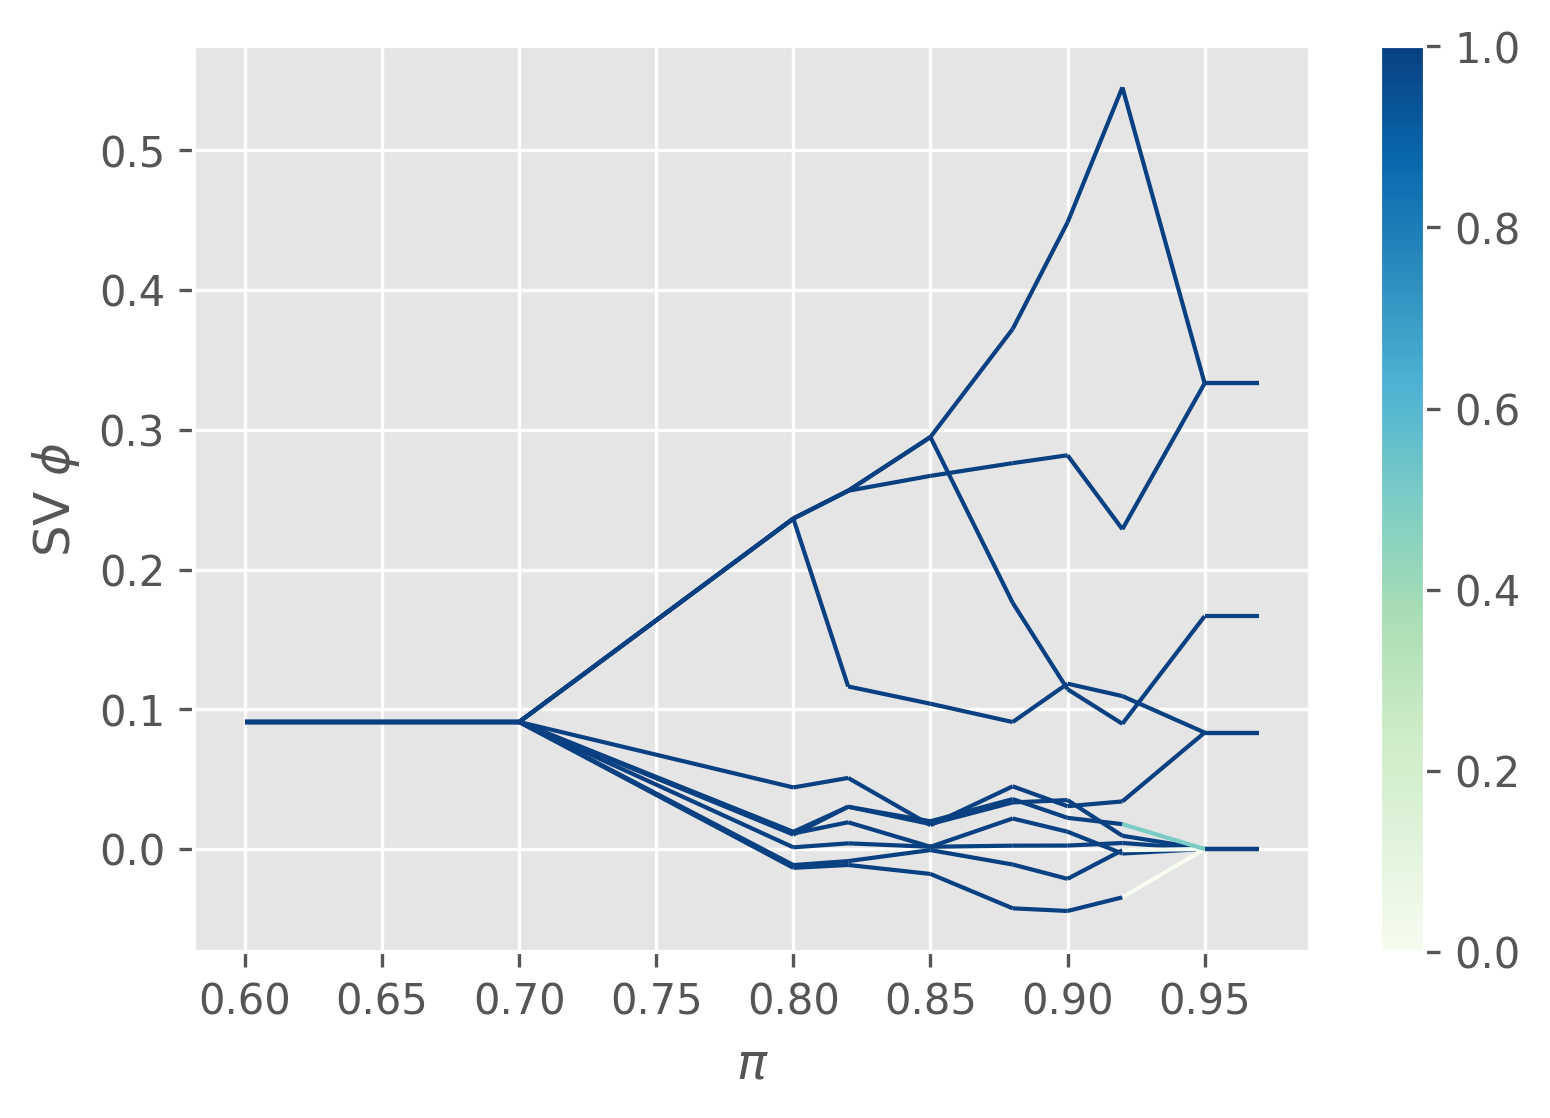

In [435]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np; np.random.seed(42)
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(dpi=300)

#convert dates to numbers first
for i in range(d):
    dates = pis[5:]
    y = svs_array[5:, i]
    c = color_line[i]
    
    
    inxval = dates
    points = np.array([inxval, y]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1],points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.cm.GnBu, linewidth=1, norm=plt.Normalize(0.0, 1.0), label='{}'.format(i))
    ax.add_collection(lc)

    # set color to date values
    lc.set_array(c)
#     lc.set_color('black')
    
#     ax.xaxis_date()
    ax.autoscale_view()
# ax.legend()
ax.set_xlabel('$\pi$')
ax.set_xticks(np.array(tick))
ax.set_ylabel('SV $\phi$')
fig.colorbar(lc, ax=ax)
plt.show()

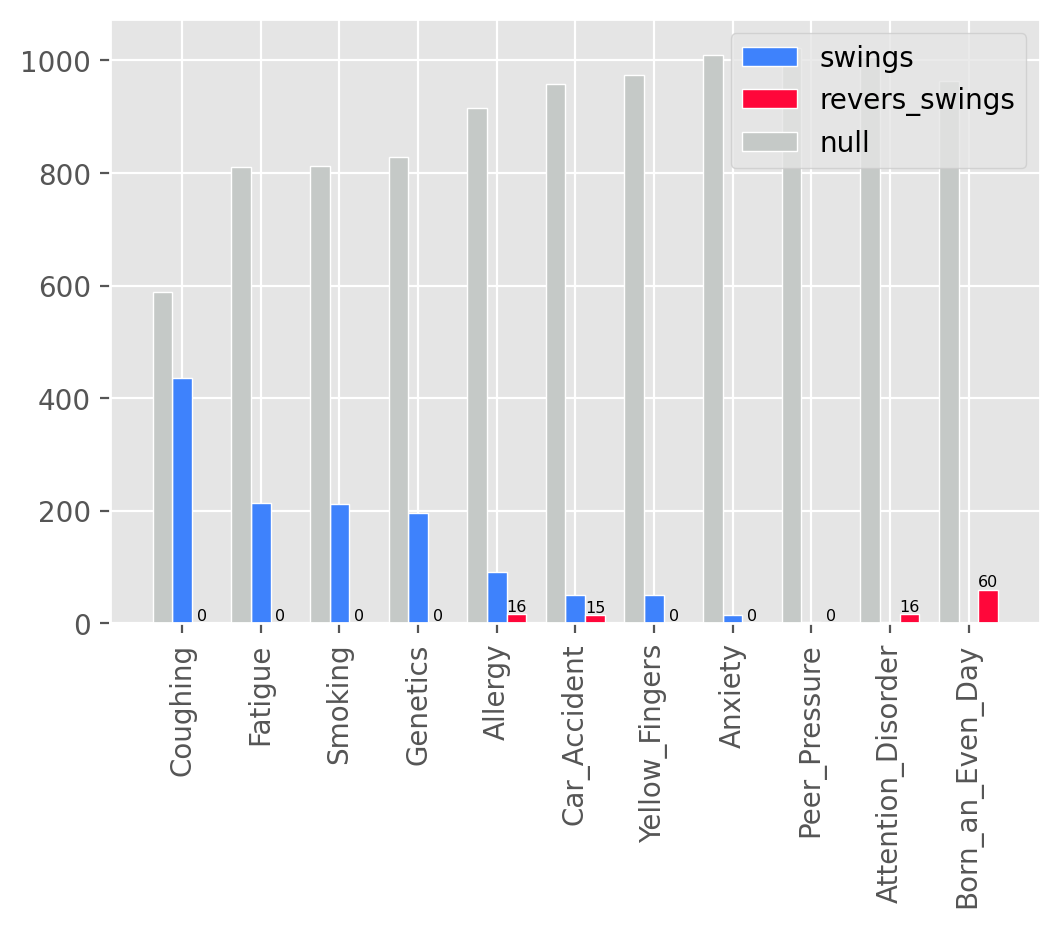

In [406]:
import numpy as np
import matplotlib.pyplot as plt
p_idx = 11
# set width of bar
barWidth = 0.5
 
# set height of bar
# labels = list(swings[0].keys())
columns_names = [X_train.columns[i] for i in range(X_train.shape[1])]
labels = columns_names
nb_swings = [swings_prop[p_idx][va][0] for va in swings_prop[p_idx].keys()]
nb_revers_swings = [swings_prop[p_idx][va][1] for va in swings_prop[p_idx].keys()]
nb_null = [swings_prop[p_idx][va][2] for va in swings_prop[p_idx].keys()]


data = {'feature_names': columns_names, 'nb_swings': nb_swings, 'nb_revers_swings':nb_revers_swings,
       'nb_null':nb_null}

fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['nb_swings'], ascending=False, inplace=True)

# Set position of bar on X axis
r1 = 2*np.arange(len(nb_swings))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

fig, ax = plt.subplots(dpi=200)
# Make the plot
plt.bar(r2, fi_df.nb_swings, color='#3e82fc', width=barWidth, edgecolor='white', label='swings')
plt.bar(r3, fi_df.nb_revers_swings, color='#ff073a', width=barWidth, edgecolor='white', label='revers_swings')
plt.bar(r1, fi_df.nb_null, color='#c5c9c7', width=barWidth, edgecolor='white', label='null')
 
# i = 0
for x,y in zip(r3, fi_df.nb_revers_swings):
    plt.text(x, y, '{}'.format(int(y)), ha='center', va= 'bottom', fontsize='xx-small')
#     plt.text(x+0.07, nb_revers_swings[i]-0.02, '%.2f' % nb_revers_swings[i], ha='center', va= 'bottom')
#     i = i + 1
# Add xticks on the middle of the group bars
# plt.xlabel('Proportion of swings, revers_swings, null', fontweight='bold')
plt.xticks([2*r + barWidth for r in range(len(nb_swings))], fi_df.feature_names, rotation='vertical')
 
# Create legend & Show graphic
plt.legend()
# plt.title('Number of swings, revers_swings, null')
plt.show()

In [312]:
# import numpy as np
# import matplotlib.pyplot as plt
# p_idx = 11
# # set width of bar
# barWidth = 0.25
 
# # set height of bar
# # labels = list(swings[0].keys())
# columns_names = [X.columns[i] for i in range(X.shape[1])]
# labels = columns_names
# nb_swings = [swings[p_idx][va][0] for va in swings_prop[p_idx].keys()]
# nb_revers_swings = [swings[p_idx][va][1] for va in swings_prop[p_idx].keys()]
# # nb_null = [swings_prop[p_idx][va][2] for va in swings_prop[p_idx].keys()]
 
# # Set position of bar on X axis
# r1 = np.arange(len(nb_swings))
# r2 = [x + barWidth for x in r1]
# # r3 = [x + barWidth for x in r2]

# fig, ax = plt.subplots(dpi=200)
# # Make the plot
# plt.bar(r1, nb_swings, color='blue', width=barWidth, edgecolor='white', label='swings')
# plt.bar(r2, nb_revers_swings, color='red', width=barWidth, edgecolor='white', label='revers_swings')
# # plt.bar(r3, nb_null, color='gray', width=barWidth, edgecolor='white', label='nul')
 
# # Add xticks on the middle of the group bars
# # plt.xlabel('Proportion of swings, revers_swings, null', fontweight='bold')
# plt.xticks([r + barWidth for r in range(len(nb_swings))], labels, rotation='vertical')
 
# # Create legend & Show graphic
# plt.legend()
# # plt.title('Proportion of swings, revers_swings, null')
# plt.show()

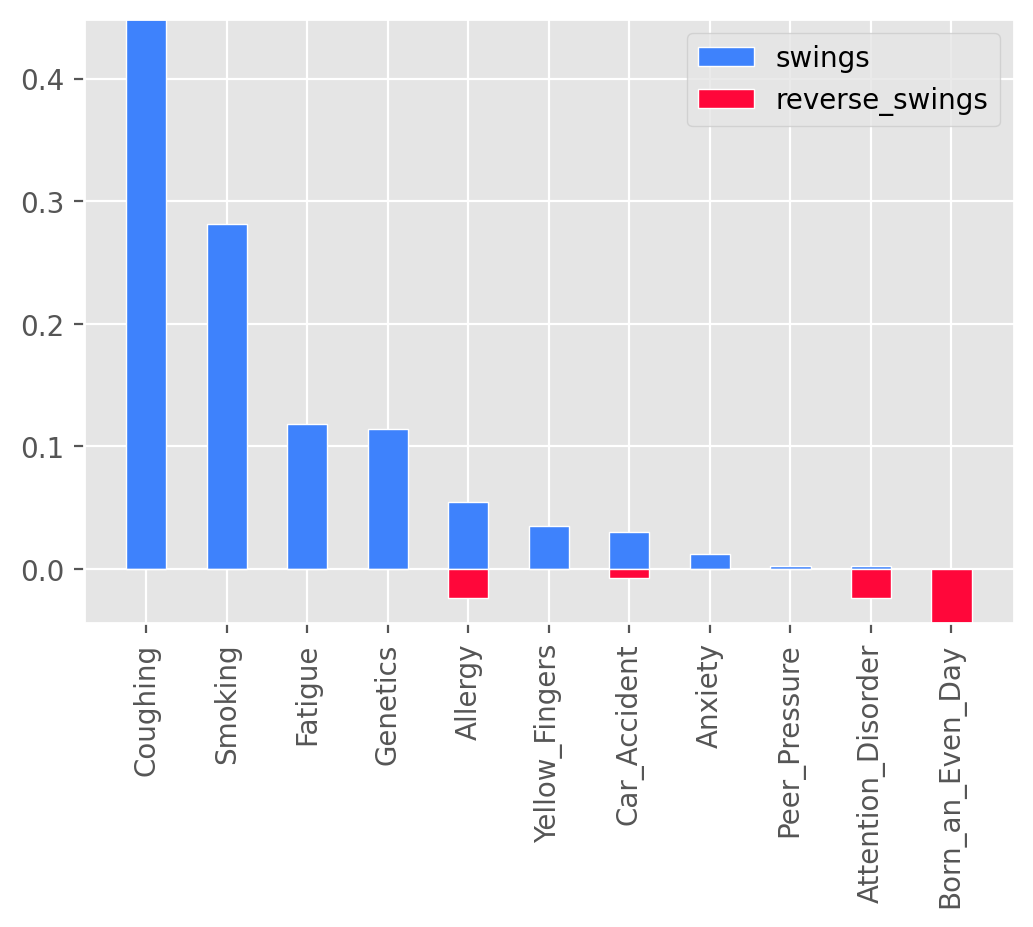

In [437]:
n = 11
X = np.arange(n)
# Y1 = (1-X/float(n)) * np.random.uniform(0.5,1.0,n)
# Y2 = (1-X/float(n)) * np.random.uniform(0.5,1.0,n)
plt.figure(dpi=200)
columns_names = [X_train.columns[i] for i in range(X_train.shape[1])]
labels = columns_names

nb_swings = [swings[p_idx][va][0] for va in swings_prop[p_idx].keys()]
nb_revers_swings = [swings[p_idx][va][1] for va in swings_prop[p_idx].keys()]

data = {'feature_names': columns_names, 'nb_swings': nb_swings, 'nb_revers_swings':nb_revers_swings}

fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['nb_swings'], ascending=False, inplace=True)

plt.bar(X, fi_df.nb_swings, facecolor='#3e82fc', edgecolor='white', label='swings', width=0.5)
plt.bar(X, fi_df.nb_revers_swings, facecolor='#ff073a', edgecolor='white', label='reverse_swings', width=0.5)

# i = 0
# for x,y in zip(X,nb_swings):
#     plt.text(x+0.07, y, '%.2f' % y, ha='center', va= 'bottom')
#     plt.text(x+0.07, nb_revers_swings[i]-0.02, '%.2f' % nb_revers_swings[i], ha='center', va= 'bottom')
#     i = i + 1
    
plt.ylim(np.min(nb_revers_swings), np.max(nb_swings))
plt.legend()
plt.xticks([r for r in range(len(nb_swings))], fi_df.feature_names, rotation='vertical')

plt.show()

In [298]:
np.min(nb_revers_swings)

-0.044372294372294355

In [259]:
columns_names

['Smoking',
 'Yellow_Fingers',
 'Anxiety',
 'Peer_Pressure',
 'Genetics',
 'Attention_Disorder',
 'Born_an_Even_Day',
 'Car_Accident',
 'Fatigue',
 'Allergy',
 'Coughing']

# Global SV

In [ ]:
def global_shap(forest, x, tx, fx, pi, data=X_train.values, C=[[]]):
    n = x.shape[0]
    svs = []
    swings = []
    swings_prop = []
    
    for i in tqdm(range(n)):
        out = acvtree.shap_values_swing_clf(x=x[i], tx=0.5, fx=fx, threshold=pi, data=data, C=[[]])
        sv, swing, swing_prop = out[0], out[1], out[2]
        svs.append(sv)
        swings.append(swing)
        swings_prop.append(swing_prop)
    return svs, swings, swings_prop
        

In [60]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []

K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_test)
    Sum_of_squared_distances.append(km.inertia_)
    

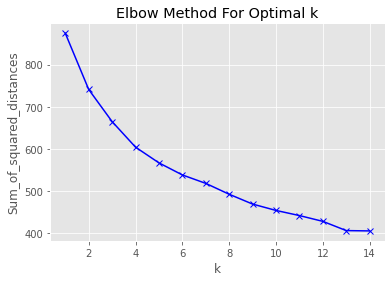

In [61]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [62]:
km = KMeans(n_clusters=8)
km = km.fit(X_test)
km.labels_

array([3, 1, 4, 4, 0, 4, 1, 3, 7, 5, 3, 2, 4, 1, 2, 5, 4, 3, 4, 3, 7, 0,
       5, 2, 4, 4, 5, 1, 4, 4, 2, 4, 5, 4, 5, 5, 2, 7, 4, 2, 1, 6, 6, 4,
       4, 1, 0, 4, 0, 5, 6, 7, 3, 1, 1, 7, 1, 4, 3, 1, 5, 4, 2, 4, 3, 7,
       6, 4, 0, 5, 2, 3, 3, 4, 4, 4, 4, 2, 3, 2, 0, 0, 6, 4, 4, 2, 3, 6,
       2, 5, 5, 5, 4, 4, 0, 1, 3, 3, 6, 7, 0, 0, 3, 5, 4, 0, 5, 7, 2, 2,
       6, 2, 1, 3, 3, 0, 0, 4, 7, 5, 1, 2, 6, 2, 5, 6, 1, 3, 5, 2, 6, 7,
       4, 5, 7, 4, 4, 7, 3, 1, 2, 4, 7, 5, 3, 0, 4, 3, 3, 3, 7, 2, 2, 3,
       4, 1, 4, 3, 3, 4, 6, 5, 4, 6, 7, 6, 2, 2, 2, 5, 4, 4, 7, 5, 3, 7,
       2, 0, 4, 1, 2, 3, 0, 4, 2, 2, 2, 1, 4, 5, 0, 7, 0, 4, 0, 0, 4, 4,
       0, 2, 2, 6, 7, 4, 4, 4, 5, 7, 2, 2, 4, 4, 0, 3, 4, 1, 4, 4, 4, 1,
       3, 3, 6, 6, 1, 1, 4, 0, 6, 6, 4, 1, 2, 2, 7, 2, 2, 4, 4, 4, 4, 2,
       3, 6, 7, 4, 5, 4, 6, 5, 0, 4, 3, 1, 0, 3, 2, 1, 2, 5, 0, 0, 1, 2,
       2, 5, 2, 1, 1, 3, 3, 7, 0, 7, 5, 5, 0, 1, 5, 4, 1, 4, 6, 1, 2, 6,
       4, 4, 5, 7, 6, 2, 3, 5, 6, 2, 7, 3, 0, 2, 6,

In [63]:
X_test_group = []
for k in range(8):
    print(np.sum(km.labels_ == k))
    X_test_group.append(X_test.values[km.labels_ == k])

38
40
69
43
92
45
37
36


In [64]:
SV_group = []
for x_group in X_test_group:
    SV_group.append(global_shap(x=x_group, tx=0.5, fx=fx, pi=pi, data=X_train.values, C=[[]]))

100%|██████████| 36/36 [1:03:06<00:00, 105.18s/it]


In [231]:
# svs_globa, swings_global, swings_prob_global = \
# global_shap(forest, x=X_test.values[:2], tx=0.5, fx=fx, pi=pi, algo='plugin', data=X_train.values, C=[[]])

[0, 4, 9]

In [66]:
buffer = np.array(SV_group)
buffer.shape

(8, 3)

In [70]:
buffer_sv = []
for b in SV_group:
    buffer_sv.append(b[0])

In [78]:
buffer_s = np.concatenate(buffer_sv)

In [79]:
from numpy import savetxt
savetxt('lucas_votsv.csv', buffer_s, delimiter=',')

In [108]:
gr = 4
for i in range(d):
    print(np.var(np.array(SV_group[gr][0])[:, i]))

0.012549105650881102
8.893875184081112e-05
8.901054578469079e-05
8.893690489898314e-05
0.0014957550999772523
8.893690489898314e-05
8.901054578469079e-05
8.901054578469079e-05
0.00824154461248461
0.012006078055656993
0.01981797821394083


In [153]:
plt.rcParams["font.weight"] = "bold"

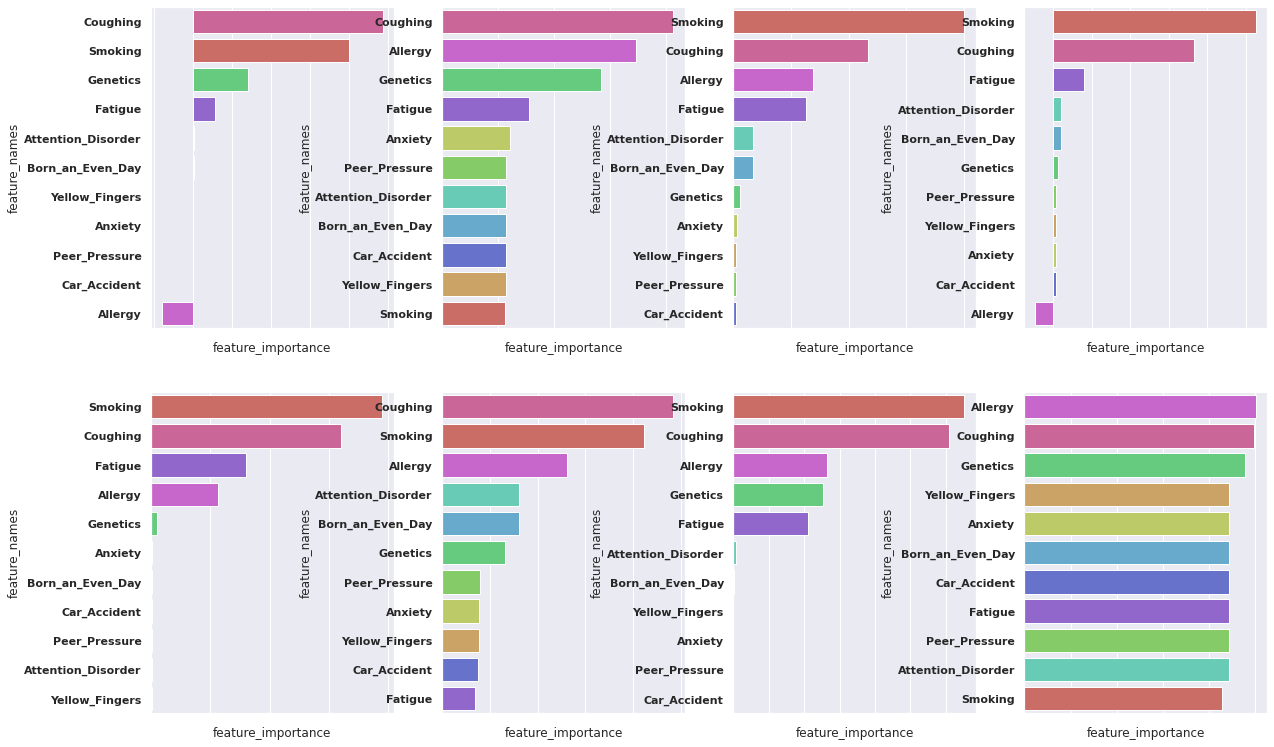

In [162]:
def plot_feature_importance_10(importance, names, ax, xlabel='SHAP values', title=' ', start=0):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    seaborn_colors = sns.color_palette("hls", 11)
    colors = {names[i]: seaborn_colors[i] for i in range(len(names))}

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Define size of bar plot
#     plt.figure(dpi=300)
    sns.set(font_scale=1)
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette=colors, ax=ax)
    if start !=0:
        ax.set(xticklabels=[])
    # Add chart labels
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel('FEATURE NAMES')
    return 0


fig, ax = plt.subplots(2, 4, figsize=(20, 13))

columns_names = [X.columns[i] for i in range(X.shape[1])]
for axis, gr in zip(ax.flat, range(len(SV_group))):
#     print('CLUSTER {}'.format(gr))
#     print(np.array(SV_group[gr][0]))
#     plt.subplot(4, 4, it+1)
    sv_fi = np.mean(np.array(SV_group[gr][0]), axis=0)
    plot_feature_importance_10(sv_fi, columns_names, ax=axis, xlabel='voting SV ', start=it)
    

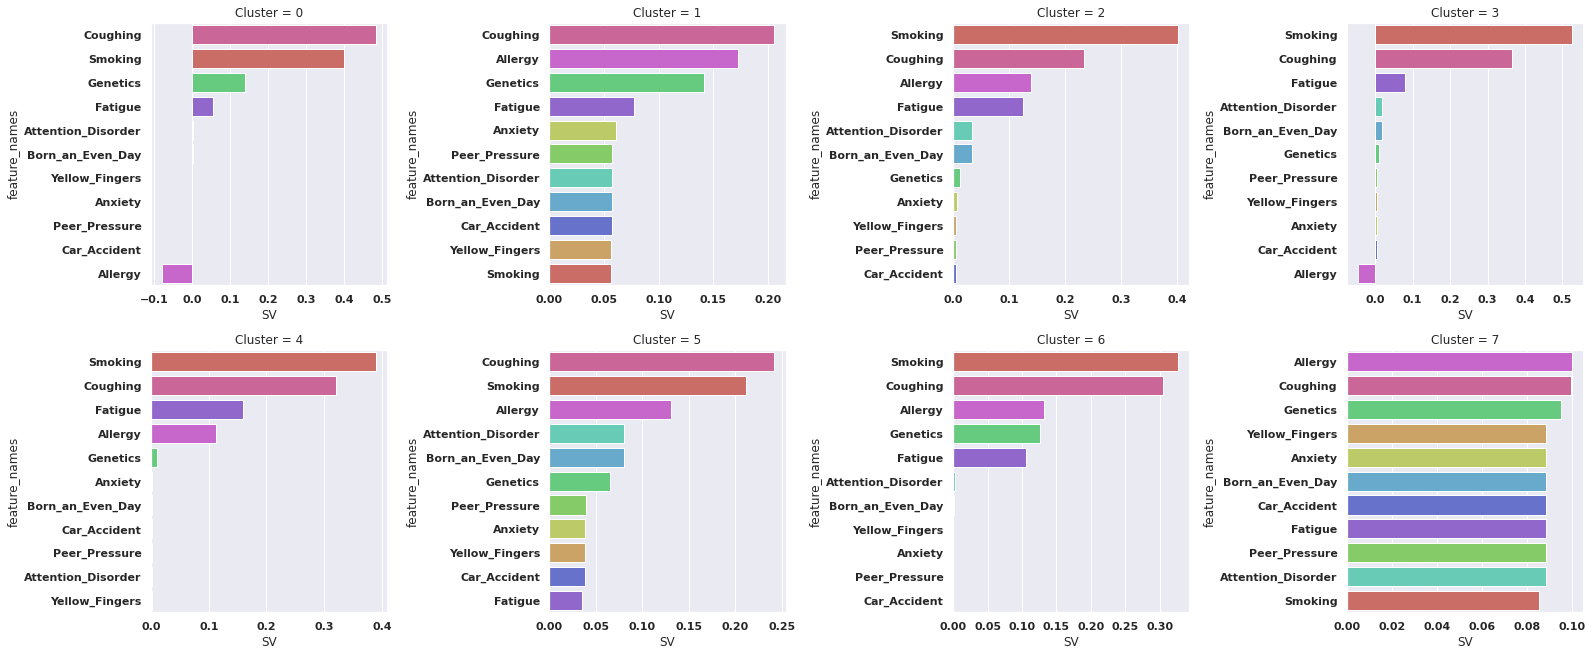

In [175]:
def plot_feature_importance_10(importance, names, ax, xlabel='SHAP values', title=' ', start=0):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    seaborn_colors = sns.color_palette("hls", 11)
    colors = {names[i]: seaborn_colors[i] for i in range(len(names))}

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'SV': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['SV'], ascending=False, inplace=True)

    # Define size of bar plot
#     plt.figure(dpi=300)
    sns.set(font_scale=1)
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['SV'], y=fi_df['feature_names'], palette=colors, ax=ax)
#     if start !=0:
#         ax.set(xticklabels=[])
    ax.set_title('Cluster = {}'.format(start))
    # Add chart labels
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel('FEATURE NAMES')
    return 0


fig, ax = plt.subplots(2, 4, figsize=(22, 9), constrained_layout=True)

columns_names = [X.columns[i] for i in range(X.shape[1])]

it = 0
for axis, gr in zip(ax.flat, range(len(SV_group))):
#     print('CLUSTER {}'.format(gr))
#     print(np.array(SV_group[gr][0]))
#     plt.subplot(4, 4, it+1)
    
    sv_fi = np.mean(np.array(SV_group[gr][0]), axis=0)
    plot_feature_importance_10(sv_fi, columns_names, ax=axis, xlabel='voting SV ', start=it)
    it += 1
    

In [185]:
x_shapleys = np.concatenate([np.array(SV_group[gr][0]) for gr in range(len(SV_group))])
x_shapleys.shape

(400, 11)

In [188]:
x_shapleys[:10]

array([[ 0.58333333,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.08333333, -0.08333333,
         0.41666667],
       [ 0.3       ,  0.        ,  0.        ,  0.        ,  0.21666667,
         0.        ,  0.        ,  0.        ,  0.05      , -0.11666667,
         0.55      ],
       [ 0.3       ,  0.        ,  0.        ,  0.        ,  0.21666667,
         0.        ,  0.        ,  0.        ,  0.05      , -0.11666667,
         0.55      ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.5       ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.5       ],
       [ 0.58333333,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.08333333, -0.08333333,
         0.41666667],
       [ 0.58333333,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.08333333, -0.08333333,
         0.416

In [189]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []

K = range(1,15)
for k in K:
    km_sv = KMeans(n_clusters=k)
    km_sv = km.fit(x_shapleys)
    Sum_of_squared_distances.append(km_sv.inertia_)

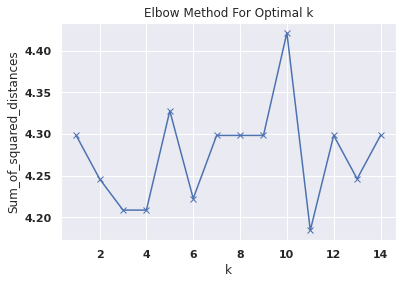

In [190]:

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [59]:
# Test

# svs_global, swings_global, swings_prob_global = \
# global_shap(forest, x=X_test.values[:2], tx=0.5, fx=fx, pi=pi, algo='plugin', data=X_train.values, C=[[]])

In [60]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []

K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_test)
    Sum_of_squared_distances.append(km.inertia_)
    

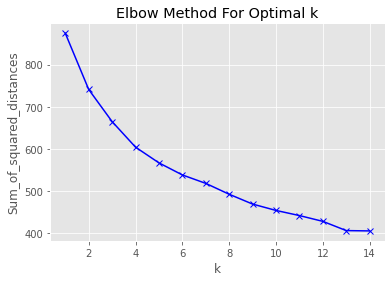

In [61]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [62]:
km = KMeans(n_clusters=8)
km = km.fit(X_test)
km.labels_

array([3, 1, 4, 4, 0, 4, 1, 3, 7, 5, 3, 2, 4, 1, 2, 5, 4, 3, 4, 3, 7, 0,
       5, 2, 4, 4, 5, 1, 4, 4, 2, 4, 5, 4, 5, 5, 2, 7, 4, 2, 1, 6, 6, 4,
       4, 1, 0, 4, 0, 5, 6, 7, 3, 1, 1, 7, 1, 4, 3, 1, 5, 4, 2, 4, 3, 7,
       6, 4, 0, 5, 2, 3, 3, 4, 4, 4, 4, 2, 3, 2, 0, 0, 6, 4, 4, 2, 3, 6,
       2, 5, 5, 5, 4, 4, 0, 1, 3, 3, 6, 7, 0, 0, 3, 5, 4, 0, 5, 7, 2, 2,
       6, 2, 1, 3, 3, 0, 0, 4, 7, 5, 1, 2, 6, 2, 5, 6, 1, 3, 5, 2, 6, 7,
       4, 5, 7, 4, 4, 7, 3, 1, 2, 4, 7, 5, 3, 0, 4, 3, 3, 3, 7, 2, 2, 3,
       4, 1, 4, 3, 3, 4, 6, 5, 4, 6, 7, 6, 2, 2, 2, 5, 4, 4, 7, 5, 3, 7,
       2, 0, 4, 1, 2, 3, 0, 4, 2, 2, 2, 1, 4, 5, 0, 7, 0, 4, 0, 0, 4, 4,
       0, 2, 2, 6, 7, 4, 4, 4, 5, 7, 2, 2, 4, 4, 0, 3, 4, 1, 4, 4, 4, 1,
       3, 3, 6, 6, 1, 1, 4, 0, 6, 6, 4, 1, 2, 2, 7, 2, 2, 4, 4, 4, 4, 2,
       3, 6, 7, 4, 5, 4, 6, 5, 0, 4, 3, 1, 0, 3, 2, 1, 2, 5, 0, 0, 1, 2,
       2, 5, 2, 1, 1, 3, 3, 7, 0, 7, 5, 5, 0, 1, 5, 4, 1, 4, 6, 1, 2, 6,
       4, 4, 5, 7, 6, 2, 3, 5, 6, 2, 7, 3, 0, 2, 6,

In [63]:
X_test_group = []
for k in range(8):
    print(np.sum(km.labels_ == k))
    X_test_group.append(X_test.values[km.labels_ == k])

38
40
69
43
92
45
37
36


In [ ]:
SV_group = []
for x_group in X_test_group:
    SV_group.append(global_shap(forest, x=x_group, tx=0.5, fx=fx, pi=pi, algo='plugin', data=X_train.values, C=[[]]))

 62%|██████▏   | 28/45 [50:11<30:38, 108.17s/it]  

In [231]:
# svs_globa, swings_global, swings_prob_global = \
# global_shap(forest, x=X_test.values[:2], tx=0.5, fx=fx, pi=pi, algo='plugin', data=X_train.values, C=[[]])

[0, 4, 9]